In [1]:
import numpy as np
import pandas as pd
from numpy.random import randn
from shapedtw.shapedtw import shape_dtw
from shapedtw.shapeDescriptors import SlopeDescriptor, PAADescriptor, CompoundDescriptor, DerivativeShapeDescriptor, DWTDescriptor
from shapedtw.dtwPlot import dtwPlot
from matplotlib import pyplot as plt
from dtw import dtw
import inspect

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



shape_dtw(x, y, subsequence_width: int,
              shape_descriptor: ShapeDescriptor,
              step_pattern: str = "symmetric2",
              dist_method: str ="euclidean",
              multivariate_version: str = "dependent",
              **kwargs)

#### Compare DTW and shapeDTW on OSUleaf dataset

Reproduce paper experiments

In [2]:
def fig_ax(figsize=(15, 5)):
    return plt.subplots(figsize=figsize)

In [3]:
# get params of a function/method
method_to_test = DWTDescriptor
signature = inspect.signature(method_to_test)
parameters = signature.parameters
parameter_names = list(parameters.keys())
print("Noms des arguments de la fonction :", parameter_names)

Noms des arguments de la fonction : ['wave_type', 'mode', 'level']


In [4]:
from aeon.datasets import load_osuleaf
X_test, y_test = load_osuleaf(split="TEST")

In [5]:
# same ts as in the paper example
ts_x = X_test[114][0]
ts_y = X_test[134][0]

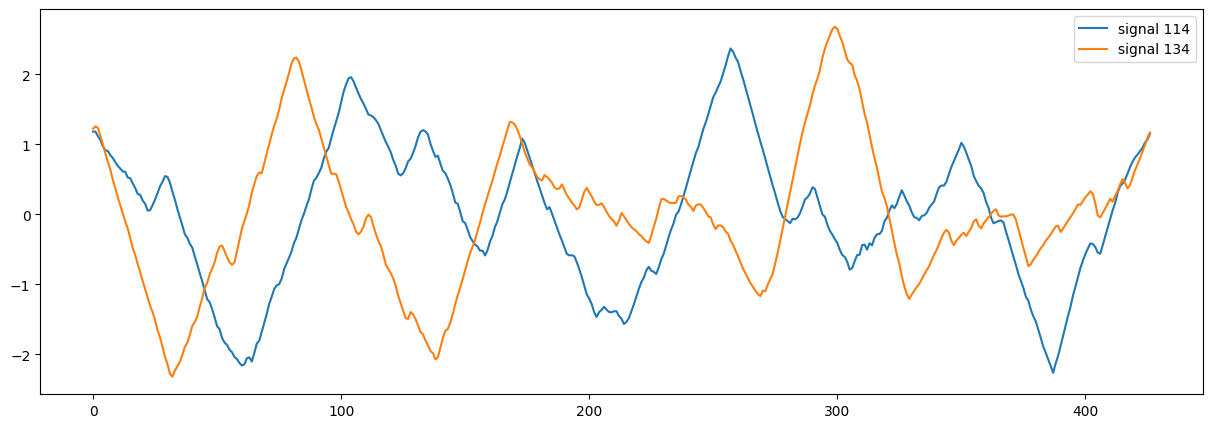

In [6]:
fig, ax = fig_ax()
ax.plot(ts_x, label="signal 114")
ax.plot(ts_y, label="signal 134")
# plt.title(f"DTW: {alignment_dtw.distance:.2f} and shapeDTW: {alignment_shape_dtw.distance:.2f}")
_ = plt.legend()

<Axes: >

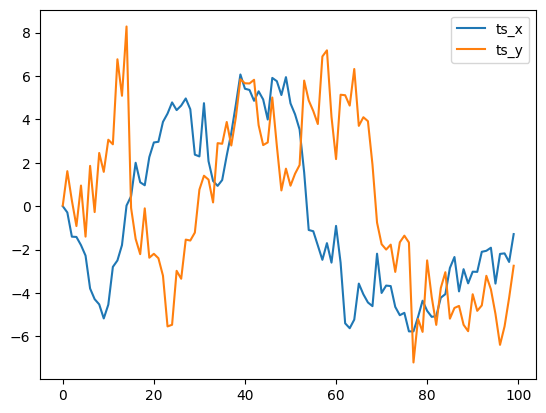

In [7]:
np.random.seed(9)
distortion_factor = 1
ts_x = np.cumsum(randn(100))
ts_y = np.concatenate(
    (
        np.cumsum(randn(15)),
        ts_x[:85]
    )
) + (randn(100)*distortion_factor)

df = pd.DataFrame({"ts_x": ts_x, "ts_y": ts_y})
df.plot()

DTW: 126.27


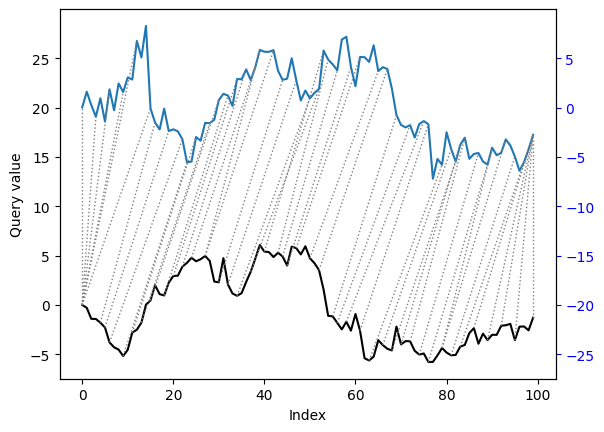

In [8]:
# dtw
alignment_dtw = dtw(ts_x, ts_y, keep_internals=True)
alignment_dtw.plot(type="twoway", offset=20)
print(f"DTW: {alignment_dtw.distance:.2f}")

shapeDTW: 184.37


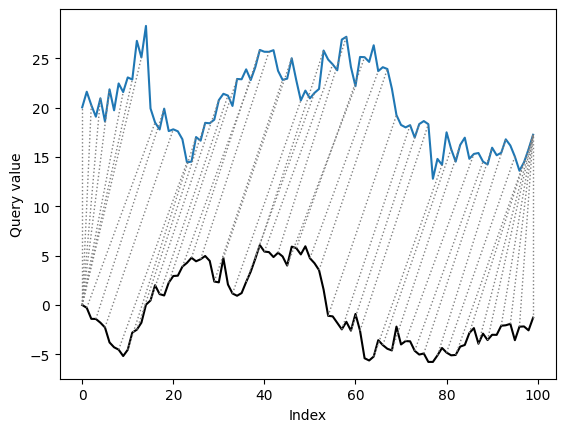

In [9]:
# shapeDTW
slope_descriptor = SlopeDescriptor(slope_window=5)
paa_descriptor = PAADescriptor(piecewise_aggregation_window=5)
compound_descriptor = CompoundDescriptor([slope_descriptor, paa_descriptor],descriptors_weights=[5., 1.])
dwt_descriptor = DWTDescriptor()
derivative_descriptor = DerivativeShapeDescriptor()

shape_dtw_results = shape_dtw(
    x = ts_x,
    y = ts_y,
    subsequence_width = len(ts_x),
    step_pattern = "symmetric2",
    shape_descriptor = derivative_descriptor
)

# distance between shape descriptors of time series, not time series itself
print(f"shapeDTW: {shape_dtw_results.distance:.2f}")
dtwPlot(shape_dtw_results, plot_type="twoway", yoffset = 20)

Distance and normalized_distance are distances between raw values of time series, whereas shape_distance and shape_normalized_distance are distances between shape descriptors of time series.

In [10]:
print(round(shape_dtw_results.distance, 2)) #distance between raw time series
print(round(shape_dtw_results.normalized_distance, 2)) #normalized distance between raw time series
print(round(shape_dtw_results.shape_distance, 2)) #distance between shape descriptors of time series, not time series itself
print(round(shape_dtw_results.shape_normalized_distance, 2)) #normalized distance between shape descriptors

184.37
0.92
2431.91
12.16


## Experiments

In [ ]:
import re
import os
import wave
import csv
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from IPython.display import Audio
import scipy
import librosa
from fastdtw import fastdtw

- Compare handwritten signatures with DTW and shapeDTW? --> not time series

- Speech recognition
- Dataset : https://www.kaggle.com/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee

Idea : 
- Compare one sentence of P1 to all sentences of P2 and compare the performances of DTW and shape DTW to find the correspondant sentence from P2

DTW can be used as a comparison module for data matching in speech recognition systems, such as identifying whether two words represent the same word.

The smaller the distance produced, the more similar between the two sound patterns. Both sound patterns are similar, thus the two voices are said to be the same.

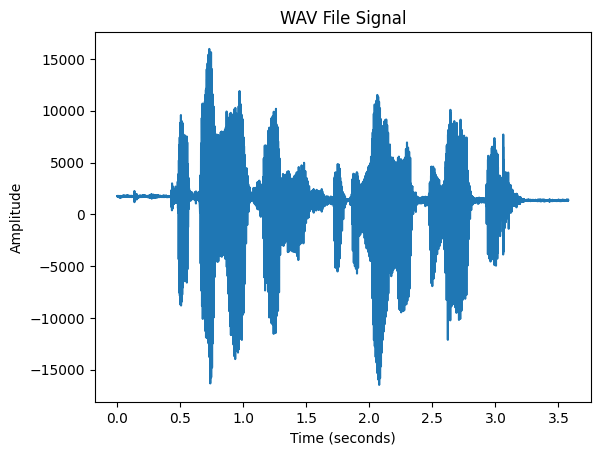

In [11]:
# Specify the path to your WAV file
wav_file_path = 'data/savee/JE_d10.wav'

# Open the WAV file
with wave.open(wav_file_path, 'rb') as wav_file:
    # Get the audio parameters
    framerate = wav_file.getframerate()
    n_frames = wav_file.getnframes()

    # Read the audio data
    signal = wav_file.readframes(n_frames)
    signal = np.frombuffer(signal, dtype=np.int16)

# Calculate the time axis
time = np.linspace(0, len(signal) / framerate, num=len(signal))

# Plot the signal
plt.plot(time, signal)
plt.title('WAV File Signal') 
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()

sample_rate, audio_data = scipy.io.wavfile.read(wav_file_path)
Audio(data=audio_data, rate=sample_rate)

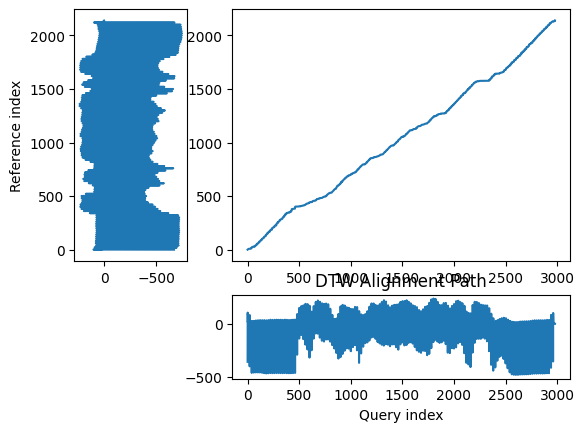

21.43678281065804


In [12]:
# DTW for speech recognition

#DC, KL, JK, JE
audio_file1 = 'data/savee/DC_a02.wav'
audio_file2 = 'data/savee/KL_a02.wav'

# Load audio files
audio1, sr1 = librosa.load(audio_file1)
audio2, sr2 = librosa.load(audio_file2)

# Extract MFCC features
mfccs1 = librosa.feature.mfcc(y=audio1, sr=sr1).T
mfccs2 = librosa.feature.mfcc(y=audio2, sr=sr2).T

# Flatten MFCC matrices
mfccs1_flat = mfccs1.flatten()
mfccs2_flat = mfccs2.flatten()

# Calculate DTW distance
alignment = dtw(mfccs1_flat, mfccs2_flat, keep_internals=True)
distance = alignment.normalizedDistance

# Plot the alignment path
alignment.plot(type="threeway", offset=-5)

plt.title('DTW Alignment Path')
plt.show()

print(distance)

copmare alignments paths between DTW and shapeDTW

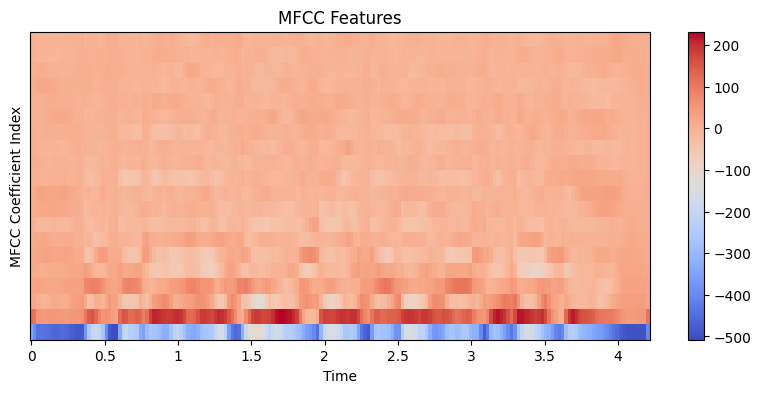

In [13]:
# Visualize MFCC

#DC, KL, JK, JE
audio_file = 'data/savee/JK_d10.wav'

# Load audio file
audio, sr = librosa.load(audio_file)

# Extract MFCC features
mfccs = librosa.feature.mfcc(y=audio, sr=sr)

# Plot MFCC features
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC Features')
plt.xlabel('Time')
plt.ylabel('MFCC Coefficient Index')
plt.show()


In [14]:
# shapeDTW for speech recognition
distance, path = fastdtw(mfccs1, mfccs2)

print("DTW Distance:", distance)
print("Optimal Path:", path)

DTW Distance: 80799.05345334113
Optimal Path: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 1), (9, 2), (10, 3), (11, 4), (12, 5), (13, 6), (14, 7), (15, 8), (16, 9), (17, 10), (18, 11), (19, 12), (20, 13), (21, 14), (22, 15), (23, 16), (24, 17), (25, 18), (26, 19), (27, 19), (28, 19), (29, 19), (30, 20), (31, 21), (32, 22), (33, 23), (34, 24), (35, 25), (36, 25), (37, 25), (38, 26), (39, 26), (40, 26), (41, 27), (42, 28), (43, 29), (44, 30), (45, 31), (46, 32), (47, 33), (48, 34), (49, 35), (50, 35), (51, 35), (52, 36), (53, 37), (54, 38), (55, 39), (56, 40), (57, 41), (58, 41), (59, 42), (60, 42), (61, 42), (62, 42), (63, 42), (64, 43), (65, 44), (66, 45), (67, 46), (68, 47), (69, 47), (70, 47), (71, 47), (72, 47), (73, 47), (74, 47), (75, 47), (76, 47), (77, 47), (78, 47), (79, 48), (80, 49), (81, 50), (82, 50), (83, 50), (84, 50), (85, 50), (86, 51), (87, 52), (88, 53), (89, 53), (90, 53), (91, 53), (92, 54), (93, 55), (94, 56), (95, 57), (96, 58), (97, 59), 

shapeDTW: 143053.24


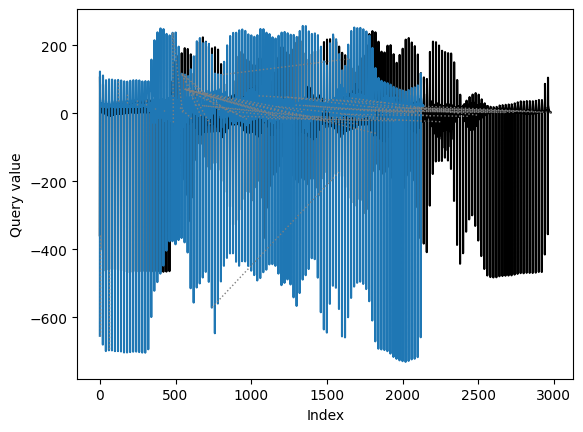

In [16]:
shape_dtw_results = shape_dtw(
    x = mfccs1_flat,
    y = mfccs2_flat,
    subsequence_width = 20,
    step_pattern = "symmetric1",
    shape_descriptor = derivative_descriptor
)

# distance between shape descriptors of time series, not time series itself
print(f"shapeDTW: {shape_dtw_results.distance:.2f}")
dtwPlot(shape_dtw_results, plot_type="twoway", yoffset = 20)

### Compare one sentence of DC to all sentences of JE with DTW

- 120 sentences pronounced per person

In [18]:
def distance_between_audios(audiofile1, audiofile2, distance):
    """Get the distance between two audio files, according to a distance (DTW or shapeDTW)
    """
    # Load audio files
    audio1, sr1 = librosa.load(audiofile1)
    audio2, sr2 = librosa.load(audiofile2)

    # Extract MFCC features
    mfccs1 = librosa.feature.mfcc(y=audio1, sr=sr1).T
    mfccs2 = librosa.feature.mfcc(y=audio2, sr=sr2).T

    # Flatten MFCC matrices
    mfccs1_flat = mfccs1.flatten()
    mfccs2_flat = mfccs2.flatten()
    
    if distance == "dtw":
        alignment = dtw(mfccs1_flat, mfccs2_flat, keep_internals=True)
        return alignment.normalizedDistance
    
    elif distance == "shapedtw":
        alignment = shape_dtw(
            x = mfccs1_flat,
            y = mfccs2_flat,
            subsequence_width = 30,
            step_pattern = "symmetric2", #cannot get normalized distance with "symmetric1"
            shape_descriptor = derivative_descriptor
            )
        # return alignment.distance
        return alignment.normalized_distance

In [24]:
def get_most_similar_sentence(audio_file_original, speaker_to_compare, distance):
    """Get the most similar sentence from the original file of the speaker_to_compare, according to a distance (DTW or shapeDTW)
    """
    min_dist = 1000000
    audio_min = ''
    
    with os.scandir('data/savee') as entries:
        files = [entry.name for entry in entries if entry.is_file()]
        files = [f"data/savee/{files[i]}" for i in range(len(files)) if files[i].startswith(speaker_to_compare)]

    for audio_to_compare in files:
        # print(audio_to_compare, distance_between_audios(audio_file_original, audio_to_compare, distance))
        calc_dist = distance_between_audios(audio_file_original, audio_to_compare, distance)
        if calc_dist < min_dist:
            min_dist = calc_dist
            audio_min = audio_to_compare

    return audio_min, min_dist

In [36]:
def get_all_distance_for_one_user(speaker, distance):
    
    speakers = ['DC', 'KL', 'JK', 'JE']
    speakers_to_compare_list = [og_speaker for og_speaker in speakers if og_speaker != speaker]
    print(speakers_to_compare_list)
    
    # dict_name = f"dict_{speaker}"
    # globals()[dict_name] = []
    res_list = []
    
    with os.scandir('data/savee') as entries:
        files = [entry.name for entry in entries if entry.is_file()]
        files = [f"data/savee/{files[i]}" for i in range(len(files)) if files[i].startswith(speaker)]
    
    for audio in files:
        # print(audio)
        res_audio = {}
        for speaker_to_compare in speakers_to_compare_list:
            res_audio[audio] = get_most_similar_sentence(audio, speaker_to_compare, distance)
            print(res_audio)
            res_list.append(res_audio)
            # globals()[dict_name].append(res_audio)
    
    print(f"Results for {speaker}: {res_list}")
    # should be able to call dict_JE, dict_KL, dict_DC, dict_JK
    
    return res_list


In [37]:
dict_DC = get_all_distance_for_one_user('DC', 'dtw')

['KL', 'JK', 'JE']
{'data/savee/DC_n13.wav': ('data/savee/KL_a04.wav', 15.756972224603858)}
{'data/savee/DC_n13.wav': ('data/savee/JK_n13.wav', 11.134520861353925)}
{'data/savee/DC_n13.wav': ('data/savee/JE_n13.wav', 10.144647538962309)}
{'data/savee/DC_su09.wav': ('data/savee/KL_h08.wav', 18.46107168189483)}
{'data/savee/DC_su09.wav': ('data/savee/JK_su09.wav', 11.73924014573822)}
{'data/savee/DC_su09.wav': ('data/savee/JE_h05.wav', 12.372670619265026)}
{'data/savee/DC_n07.wav': ('data/savee/KL_a10.wav', 17.389832739896853)}
{'data/savee/DC_n07.wav': ('data/savee/JK_n07.wav', 12.549082024572552)}
{'data/savee/DC_n07.wav': ('data/savee/JE_n07.wav', 11.43204375222545)}
{'data/savee/DC_h01.wav': ('data/savee/KL_f10.wav', 19.537322336581422)}
{'data/savee/DC_h01.wav': ('data/savee/JK_a01.wav', 10.834436780992938)}
{'data/savee/DC_h01.wav': ('data/savee/JE_h01.wav', 11.174070525198971)}
{'data/savee/DC_h15.wav': ('data/savee/KL_h15.wav', 19.77337548677611)}
{'data/savee/DC_h15.wav': ('data

In [ ]:
csv_file = 'data/results/DC_dtw.csv'

with open(csv_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Data'])  # Header can be customized as needed
    for item in dict_DC:
        writer.writerow([json.dumps(item)])

print(f'CSV file "{csv_file}" has been created.')

In [ ]:

def get_metrics(speaker, data):
    """Get the number of truly and wrongly matched sentences for a speaker

    Args:
        speaker (str): speaker to compare to (DC, KL, JK, JE)
        data (list): list of dictionaries with the original sentence as key and the most similar sentence as value

    Returns:
        dict: dictionary with the number of truly and wrongly matched sentences for each speaker
    """
    pattern = r'/[A-Z]+_([a-z0-9]+)\.'
    
    true_count_DC, false_count_DC = 0, 0
    true_count_KL, false_count_KL = 0, 0
    true_count_JE, false_count_JE = 0, 0
    true_count_JK, false_count_JK = 0, 0
    res_dict = {}
    
    # Iterate through the list of dictionaries
    for entry in data:
        key, (value, distance) = entry.popitem()
        
        true_match_sentence = re.search(pattern, key)
        true_sentence_nb = true_match_sentence.group(1) if true_match_sentence else None
        
        similar_match_sentence = re.search(pattern, value)
        similar_sentence_nb = similar_match_sentence.group(1) if similar_match_sentence else None
        
        speaker_code = value.split('/')[-1].split('_')[0]
        
        if true_sentence_nb == similar_sentence_nb:
            if speaker_code == 'KL':
                true_count_KL += 1
            elif speaker_code == 'JE':
                true_count_JE += 1
            elif speaker_code == 'JK':
                true_count_JK += 1
            else:
                true_count_DC += 1
        else:
            if speaker_code == 'KL':
                false_count_KL += 1
            elif speaker_code == 'JE':
                false_count_JE += 1
            elif speaker_code == 'JK':
                false_count_JK += 1
            else:
                false_count_DC += 1
    
    for speaker_ in ['KL', 'JE', 'JK', 'DC']:
        res_dict[f"{speaker_} compared to {speaker}"] = {
            'Correct matches': eval(f'true_count_{speaker_}'),
            'Wrong matches': eval(f'false_count_{speaker_}')
        }
        
    return res_dict

In [ ]:
get_metrics('DC', dict_DC)